In [39]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold, train_test_split, cross_val_predict
from lightgbm import LGBMRegressor

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('data/train.csv.gz', compression='gzip')
train = train.drop(train[train.price == 0].index)

test = pd.read_csv('data/test.csv.gz', compression='gzip')

In [41]:
# кросс-валидация

def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred) / (y_true)).replace([-np.inf, np.inf], np.nan).dropna())*100

test['price'] = -1

data = pd.concat([train, test], 0) #, sort=False)
data.reset_index(drop=True, inplace=True)

def cv_mode(CV):
    
    if CV:
    
        cv = KFold(n_splits=3, shuffle=False, random_state=42).split(data.iloc[:train.shape[0]])
    
    else:
        i_tr = data.iloc[:train.shape[0]].index
        i_tst = data.iloc[train.shape[0]:].index
        cv = (i_tr, i_tst)
    
    return cv

def make_prediction( model, X, y, i_tr, i_tst):
    X_train, X_test = X.iloc[i_tr, :], X.iloc[i_tst, :]
    y_train, y_test = np.log1p(y.iloc[i_tr]), y.iloc[i_tst]
    model.fit(X_train, y_train)
    prediction = np.expm1(model.predict(X_test))
    return prediction, MAPE(y_test, prediction)
        
    
def cross_val(model, X, y, CV=True):
    cv = cv_mode(CV)
    scores = []
    for i_tr, i_tst in cv:
        _, score = make_prediction(model, X, y, i_tr, i_tst)
        scores.append(score)
    return np.mean(scores), np.std(scores)


def make_subm(model, X, y, filename, CV=False):
    cv = cv_mode(CV)
    (i_tr, i_tst) = cv
    prediction, _ = make_prediction(model, X, y, i_tr, i_tst)
    subm['price'] = prediction
    subm.to_csv(filename, index=False)
    pass

In [ ]:
# Понятно, что тут тоже нужно писать свой класс, иначе в кросс-валидацию это не вставишь

In [62]:
from sklearn.base import BaseEstimator

class SimpleStacking(BaseEstimator):  

    def __init__(self, models, meta_model):
    
        self.models = models
        self.meta_model = meta_model
        self.n = len(models)
        
    def fit(self, X, y, cv=3, random_state=42):
        
        self.valid =np.zeros((X.shape[0], self.n))
            
        for t, est in enumerate(self.models):
            # oob-ответы алгоритмов
            self.valid[:, t] = cross_val_predict(est, X, y, cv=cv, n_jobs=-1, method='predict')
            est.fit(X, y)
            
        # обучение метамодели
        self.meta_model.fit(self.valid, y)  
            
        return self
    


    def predict(self, X):
        
        # заполение матрицы для мета-классификатора
        X_meta = np.zeros((X.shape[0], self.n))
        
        for t, est in enumerate(self.models):
            X_meta[:, t] = est.predict(X)
        
        preds = self.meta_model.predict(X_meta)
        
        return (preds)
    

In [ ]:
# что можно улучшить? добавить случайный шум, возможность передавать моделям свое подмножество признаков, 
# возможность передавать сложную кросс-валидацию, возможность в добавлять признак - статистику по фолдам,
# что-нибудь сложное с early stopping

In [86]:
# Проверим что получилось

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


est1 = LGBMRegressor()
est2 = RandomForestRegressor(n_jobs=-1, random_state=42)
est3 = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=10, n_jobs=-1))
est4 = make_pipeline(StandardScaler(), Ridge(random_state=42)) 

num_cols = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'square_feet',
            'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
            'minimum_nights', 'latitude', 'longitude']

X = data[num_cols].fillna(0)
y = data.price

In [43]:
scores_lst = []
preds_arr = np.zeros((test.shape[0], 4))

for i, est in enumerate([est1, est2, est3, est4]):
    scores_lst.append(cross_val(est, X, y)[0])
    cv = cv_mode(False)
    (i_tr, i_tst) = cv
    preds_arr[:, i], _ = make_prediction(est, X, y, i_tr, i_tst)
    
scores_lst

[31.39410883090633, 34.520700065622613, 35.748992887984123, 45.819840708236505]

In [44]:
preds_arr

array([[  31.92865069,   33.91812974,   34.02195111,   55.1441501 ],
       [  61.66578144,   85.22592911,   49.43762084,   61.06297027],
       [  39.40565591,   53.91337   ,   71.73147697,   76.79511875],
       ..., 
       [ 110.1367222 ,  143.91695883,  154.80188748,  145.92893965],
       [ 110.50697971,  110.9237356 ,   96.52461413,  123.73286208],
       [  37.36269398,   34.67461508,   63.45975569,   53.07713487]])

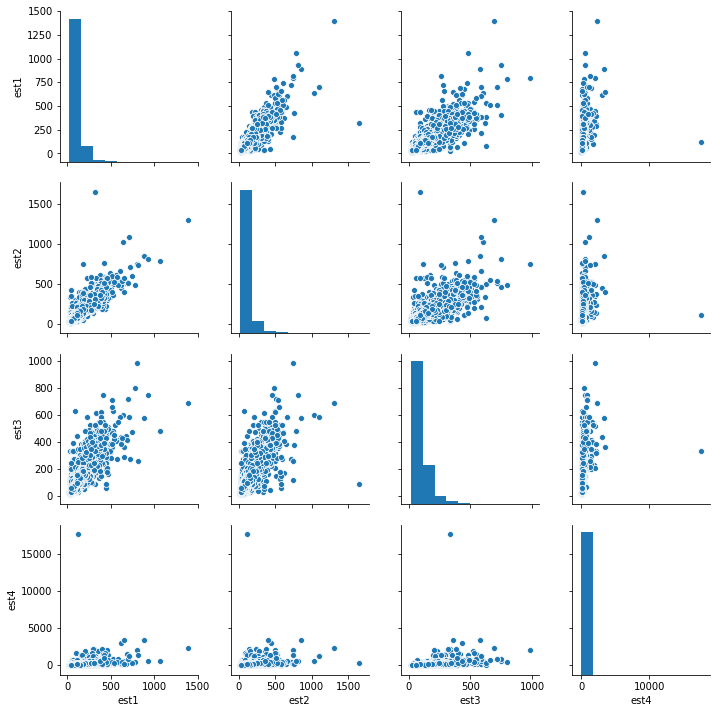

In [45]:
sns.pairplot(pd.DataFrame(data=preds_arr, columns=['est1', 'est2', 'est3', 'est4']))

In [90]:
# Все равно начнем с простого, усредним

cv = cv_mode(True)
scores = []
for i_tr, i_tst in cv:
    X_train, X_test = X.iloc[i_tr, :], X.iloc[i_tst, :]
    y_train, y_test = np.log1p(y.iloc[i_tr]), y.iloc[i_tst]
    
    preds_all = np.array([0.]*X_test.shape[0])
    for i, est in enumerate([est2, est3, est4]):   
        est.fit(X_train, y_train)
        prediction = np.expm1(est.predict(X_test))
        preds_all += prediction
    scores.append(MAPE(y_test, preds_all/3))
    
np.mean(scores)

35.579208504330019

In [71]:
# стекинг

In [75]:
model = SimpleStacking(models=[est2, est3, est4], meta_model= make_pipeline(StandardScaler(), Ridge()))

cross_val(model, X, y)

(32.895979123768122, 1.5809299236578789)

In [ ]:
# есть еще вот такая штука

In [97]:
from mlxtend.regressor import StackingRegressor

In [95]:
model = StackingRegressor([est2, est3, est4], make_pipeline(StandardScaler(), Ridge()))

cross_val(model, X, y)

(36.38925111466245, 1.722477444368993)